# Pairwise Distances 

## An embarrassingly parallel problem.

In [1]:
import numpy as np

In [2]:
from scipy.spatial.distance import pdist

In [3]:
import pub_helpers as pub

### Start Small

In [4]:
shape = (1000, 300)

In [5]:
pub.format_memory(pub.size(shape))

'2.4E+06 bytes.'

In [6]:
pub.format_pairs(pub.num_pairs(shape))

'499500 pairwise comparisons.'

In [7]:
pub.format_memory(pub.num_pairs(shape))

'3.996E+06 bytes.'

In [8]:
arr = np.random.sample(shape)

In [9]:
%%time
scipy_dist = pdist(arr, "euclidean")

CPU times: user 116 ms, sys: 0 ns, total: 116 ms
Wall time: 118 ms


### Larger

In [10]:
shape_l = (10000, 300)

In [11]:
pub.format_memory(pub.size(shape_l))

'2.4E+07 bytes.'

In [12]:
pub.format_pairs(pub.num_pairs(shape_l))

'4.9995E+07 pairwise comparisons.'

In [13]:
pub.format_memory(pub.num_pairs(shape_l))

'3.9996E+08 bytes.'

In [14]:
arr_l = np.random.sample(shape_l)

In [15]:
%%time
scipy_dist = pdist(arr_l, "euclidean")

CPU times: user 10.9 s, sys: 20 ms, total: 10.9 s
Wall time: 10.9 s


## Local Parallel Approaches:

In [16]:
from ipyparallel import Client

In [17]:
rclient = Client(profile="mylocal")

In [18]:
dview = rclient.direct_view()

In [19]:
lview = rclient.load_balanced_view()

In [20]:
lview.block

False

### Silly

In [21]:
from scipy.spatial.distance import euclidean

In [22]:
def parallel_distance(argv):
    (matrix, i, j) = argv
    return (euclidean(matrix[i, :], matrix[j, :]), i, j)

In [23]:
arr_s = np.random.sample((10, 365))

In [24]:
%%time
pdist(arr_s)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 120 µs


array([ 7.69106835,  7.82960738,  7.92083473,  7.45475052,  7.72887399,
        7.6745607 ,  7.82930681,  7.79978895,  8.02424036,  7.96520435,
        8.03889274,  8.12097772,  8.25726012,  7.71454792,  7.77906949,
        7.56367922,  7.61689153,  7.7277469 ,  8.18284827,  8.00660823,
        7.63662404,  7.96945569,  7.62378236,  7.95258099,  7.61276661,
        7.6899261 ,  7.7818716 ,  7.68072532,  7.65734471,  7.49017931,
        7.937314  ,  7.8597923 ,  7.42085203,  7.77926115,  8.23445877,
        7.69966229,  8.11080204,  7.76714485,  7.84786048,  7.46872854,
        7.47155998,  7.71924349,  7.49130884,  7.58271939,  7.86495515])

In [25]:
from tqdm import tnrange

In [26]:
dview.push({"euclidean": euclidean}, block=True)

[None, None, None]

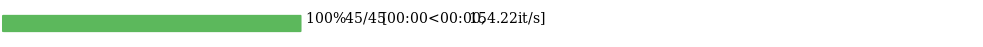

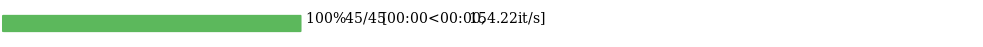

In [27]:
arr_res = np.zeros(arr_s.shape)
bar = tnrange(pub.num_pairs(arr_s.shape))
res_it = lview.map(parallel_distance, [(arr_s, i, j) for i in range(arr_s.shape[0] - 1) for j in range(i + 1, arr_s.shape[0])])
for res in res_it:
    arr_res[res[1], res[2]] = res[0]
    bar.update()

In [28]:
lview.wait()

True

In [29]:
arr_res

array([[ 0.        ,  7.69106835,  7.82960738, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  7.96520435, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

## Smarter

In [30]:
from ipyparallel import require

In [31]:
with dview.sync_imports():
    import numpy

importing numpy on engine(s)


In [32]:
def chunk_distance(i):
    global arr
    res = numpy.zeros(arr.shape[0] - i)
    for (k, j) in enumerate(range(i + 1, arr.shape[0])):
        res[k] = euclidean(arr[i], arr[j])
    return res

In [33]:
dview.push({"arr": arr}, block=True)

[None, None, None]

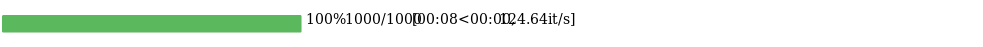

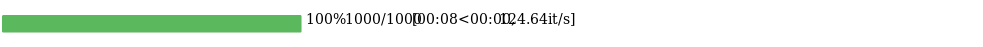

In [34]:
bar = tnrange(arr.shape[0])
res_it = lview.map(chunk_distance, list(range(arr.shape[0])))
for res in res_it:
    bar.update()

In [35]:
from tqdm import trange

In [36]:
bar = trange(arr.shape[0])
res_it = lview.map(chunk_distance, list(range(arr.shape[0])))
for res in res_it:
    bar.update()

  0%|          | 0/1000 [00:00<?, ?it/s]

 96%|█████████▋| 964/1000 [00:07<00:00, 246.71it/s]

In [37]:
dview.push({"arr": arr_l}, block=True)

[None, None, None]

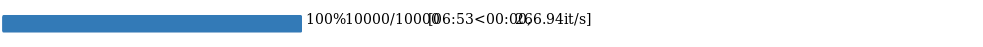

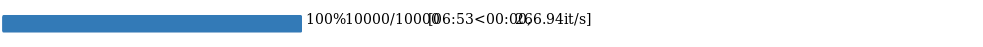

100%|██████████| 1000/1000 [00:07<00:00, 130.46it/s]


In [38]:
bar = tnrange(arr_l.shape[0])
res_it = lview.map(chunk_distance, list(range(arr_l.shape[0])))
for res in res_it:
    bar.update()